In [1]:
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals

import sys

from itertools import chain
from docopt import docopt
from sumy import __version__
from sumy.utils import ItemsCount, get_stop_words, fetch_url
from sumy.models import TfDocumentModel
from sumy._compat import to_string
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.random import RandomSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.evaluation import precision, recall, f_score, cosine_similarity, unit_overlap
from sumy.evaluation import rouge_1, rouge_2, rouge_l_sentence_level, rouge_l_summary_level 

In [2]:
PARSERS = {
    "html": HtmlParser,
    "plaintext": PlaintextParser,
}

In [3]:
def build_random(parser, language):
    return RandomSummarizer()

def build_luhn(parser, language):
    summarizer = LuhnSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_edmundson(parser, language):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.null_words = get_stop_words(language)
    summarizer.bonus_words = parser.significant_words
    summarizer.stigma_words = parser.stigma_words

    return summarizer

def build_lsa(parser, language):
    summarizer = LsaSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_text_rank(parser, language):
    summarizer = TextRankSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_lex_rank(parser, language):
    summarizer = LexRankSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_sum_basic(parser, language):
    summarizer = SumBasicSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_kl(parser, language):
    summarizer = KLSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def evaluate_cosine_similarity(evaluated_sentences, reference_sentences):
    evaluated_words = tuple(chain(*(s.words for s in evaluated_sentences)))
    reference_words = tuple(chain(*(s.words for s in reference_sentences)))
    evaluated_model = TfDocumentModel(evaluated_words)
    reference_model = TfDocumentModel(reference_words)

    return cosine_similarity(evaluated_model, reference_model)

def evaluate_unit_overlap(evaluated_sentences, reference_sentences):
    evaluated_words = tuple(chain(*(s.words for s in evaluated_sentences)))
    reference_words = tuple(chain(*(s.words for s in reference_sentences)))
    evaluated_model = TfDocumentModel(evaluated_words)
    reference_model = TfDocumentModel(reference_words)

    return unit_overlap(evaluated_model, reference_model)

In [4]:
AVAILABLE_METHODS = {
    "luhn": build_luhn,
    "edmundson": build_edmundson,
    "lsa": build_lsa,
    "text-rank": build_text_rank,
    "lex-rank": build_lex_rank,
    "sum-basic": build_sum_basic,
    "kl": build_kl,
}

AVAILABLE_EVALUATIONS = (
    ("Precision", False, precision),
    ("Recall", False, recall),
    ("F-score", False, f_score),
    ("Cosine similarity", False, evaluate_cosine_similarity),
    ("Cosine similarity (document)", True, evaluate_cosine_similarity),
    ("Unit overlap", False, evaluate_unit_overlap),
    ("Unit overlap (document)", True, evaluate_unit_overlap),
    ("Rouge-1", False, rouge_1),
    ("Rouge-2", False, rouge_2),
    ("Rouge-L (Sentence Level)", False, rouge_l_sentence_level),
    ("Rouge-L (Summary Level)", False, rouge_l_summary_level)
)

In [5]:
#text = 'From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster debut opposite Shah Rukh Khan in Chaiyya Chaiyya from Dil Se (1998), is still remembered for the song. However, for trolls, she is a woman first and what matters right now is that she divorced a ?rich man?.  On Wednesday, Malaika Arora shared a gorgeous picture of herself on Instagram and a follower decided to troll her for using her ?alumni? (read alimony) money to wear ?short clothes and going to gym or salon?. Little did he/she know that the Munni Badnam star would reply with the perfect comeback. Take a look at the interaction:     Super excited to be affiliated with Khanna Jewellers @khannajewellerskj as their brand ambassador. Crafted to perfection, their stunning statement jewellery is a must have for every jewellery lover. #khannajewellers...#maksquad?? #hair @hairbypriyanka #stylist @manekaharisinghani #manager @ektakauroberoi #mua? @subbu28 #photographer @prasdnaik A post shared by Malaika Arora Khan (@malaikaarorakhanofficial) on Aug 2, 2017 at 6:20am PDT Then, Malaika decided to reply: The entire conversation only proves that no matter if a woman is successful, she will be attacked the moment she decides to step out of bounds the society decided for her. Apart from being a successful woman who lives life on her own terms, Malaika has literally played all the roles traditionally prescribed for a woman - she married quite early, had a son and raised him and was always around with the ?khandan?. But then, she got divorced and alimony is the taunt being thrown at her. The details of the alimony are only known to Malaika, her husband Arbaaz Khan and perhaps the family. The couple has handled the divorce with the utmost dignity. But we can vouch for the fact that she did not  need an alimony to buy clothes (short or not, her choice), go on vacations and enjoy her life. If anything, she is as successful, if not more, than her ex-husband.What happened between Arbaaz and Malaika is their personal concern. But to claim that Malaika married and then divorced Arbaaz for money doesn?t hold water. For those who do not agree, please get a course in feminism and for others, here?s a playlist of some of her most popular songs. Follow @htshowbiz for more'
#reference = 'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [7]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd

text_data = pd.read_csv("news_summary.csv", header=None, encoding = "ISO-8859-1")
#text_all = text_data[5].values
text_all = text_data[5].values[1:]
#reference_all = text_data[4].values
reference_all = pd.read_csv("extract_luhn.csv", header=None, encoding = "ISO-8859-1").drop(0)
reference_all = reference_all[1].values

In [ ]:
for a, b in AVAILABLE_METHODS.items():
    names = "txt2ext_result_"+a+".csv"
    raw_data = {'Precision':[], 'Recall':[], 'F-score':[], 'Cosine similarity':[], 'Cosine similarity (document)':[], 'Unit overlap':[], 'Unit overlap (document)':[], 'Rouge-1':[], 'Rouge-2':[], 'Rouge-L (Sentence Level)':[], 'Rouge-L (Summary Level)':[]}
    columns = [i[0] for i in AVAILABLE_EVALUATIONS]
    df = DataFrame(raw_data, columns = columns)
    #for i in range(1, len(text_all)):
    for i in range(0, len(reference_all)):
        summarizer_builder = b
        parser = PlaintextParser(text_all[i], Tokenizer('english'))

        summarizer = summarizer_builder(parser, 'english')
        document = parser.document
        items_count = ItemsCount(2)
        reference_summary = reference_all[i]
        try:
            evaluated_sentences = summarizer(document, items_count)
        except:
            continue
        reference_document = PlaintextParser.from_string(reference_summary,Tokenizer("english"))
        reference_sentences = reference_document.document.sentences
        raw_data = {}
#         print("refer:\n",reference_sentences,"\neval:\n",evaluated_sentences,"\n")
        for name, evaluate_document, evaluate in AVAILABLE_EVALUATIONS:
            if evaluate_document:
                result = evaluate(evaluated_sentences, document.sentences)
            else:
                try :
                    result = evaluate(evaluated_sentences, reference_sentences)
                except :
                    break
            raw_data[name]=float(result)
        if(len(raw_data) == 11):
            df.loc[len(df)] = raw_data
    print("================================ "+ a + " done! ==============================")
    df.to_csv(names)

# 알고리즘별 그래프

In [8]:
%matplotlib inline 
import math
import matplotlib.pyplot as plt
import scipy as sp
from pylab import figure, axes, pie, title, savefig

In [8]:
col = [i[0] for i in AVAILABLE_EVALUATIONS]

In [9]:
# luhn
static_luhn = pd.read_csv("txt2ext_result_luhn.csv", header=None, encoding = "ISO-8859-1")
static_luhn = static_luhn.drop(0,0)
static_luhn = static_luhn.drop(0,1)
static_luhn.columns=col
static_luhn[col] = static_luhn[col].astype(float)
static_luhn = static_luhn.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# edmundson
static_edmundson = pd.read_csv("txt2ext_result_edmundson.csv", header=None, encoding = "ISO-8859-1")
static_edmundson = static_edmundson.drop(0,0)
static_edmundson = static_edmundson.drop(0,1)
static_edmundson.columns=col
static_edmundson[col] = static_edmundson[col].astype(float)
static_edmundson = static_edmundson.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# lsa
static_lsa = pd.read_csv("txt2ext_result_lsa.csv", header=None, encoding = "ISO-8859-1")
static_lsa = static_lsa.drop(0,0)
static_lsa = static_lsa.drop(0,1)
static_lsa.columns=col
static_lsa[col] = static_lsa[col].astype(float)
static_lsa = static_lsa.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# text-rank
static_text_rank = pd.read_csv("txt2ext_result_text-rank.csv", header=None, encoding = "ISO-8859-1")
static_text_rank = static_text_rank.drop(0,0)
static_text_rank = static_text_rank.drop(0,1)
static_text_rank.columns=col
static_text_rank[col] = static_text_rank[col].astype(float)
static_text_rank = static_text_rank.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# lex-rank
static_lex_rank = pd.read_csv("txt2ext_result_lex-rank.csv", header=None, encoding = "ISO-8859-1")
static_lex_rank = static_lex_rank.drop(0,0)
static_lex_rank = static_lex_rank.drop(0,1)
static_lex_rank.columns=col
static_lex_rank[col] = static_lex_rank[col].astype(float)
static_lex_rank = static_lex_rank.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# sum-basic
static_sum_basic = pd.read_csv("txt2ext_result_sum-basic.csv", header=None, encoding = "ISO-8859-1")
static_sum_basic = static_sum_basic.drop(0,0)
static_sum_basic = static_sum_basic.drop(0,1)
static_sum_basic.columns=col
static_sum_basic[col] = static_sum_basic[col].astype(float)
static_sum_basic = static_sum_basic.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

#kl
static_kl = pd.read_csv("txt2ext_result_kl.csv", header=None, encoding = "ISO-8859-1")
static_kl = static_kl.drop(0,0)
static_kl = static_kl.drop(0,1)
static_kl.columns=col
static_kl[col] = static_kl[col].astype(float)
static_kl = static_kl.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

## luhn 그래프

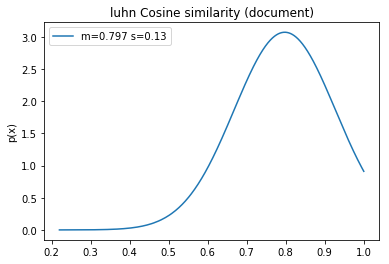

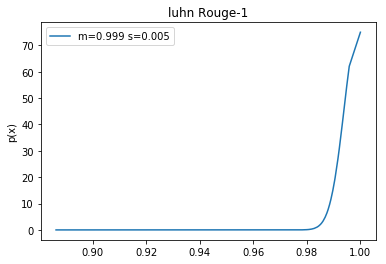

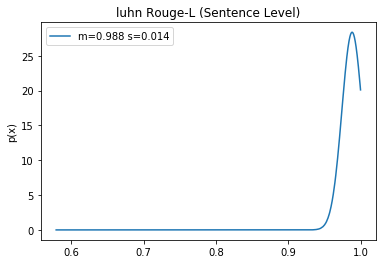

In [10]:
for col in static_luhn.columns:
    x = [i for i in static_luhn.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("luhn " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2ext_luhn_"+col+".png")

## edmundson 그래프

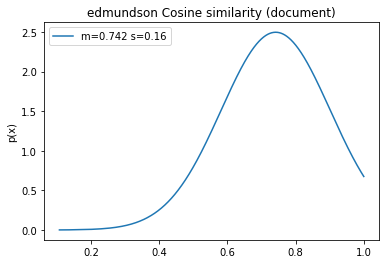

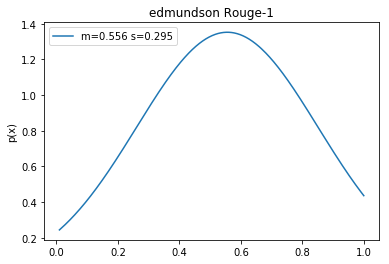

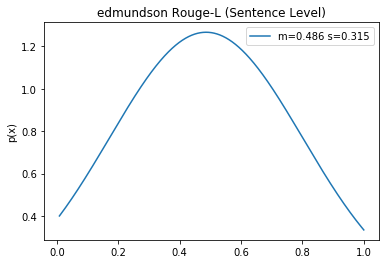

In [11]:
for col in static_edmundson.columns:
    x = [i for i in static_edmundson.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("edmundson " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2ext_edmundson_"+col+".png")

## lsa 그래프

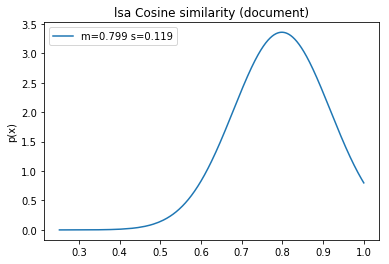

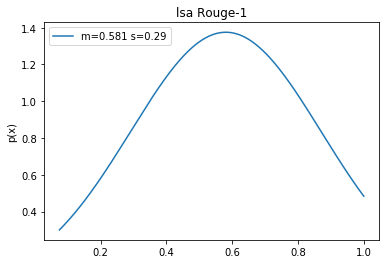

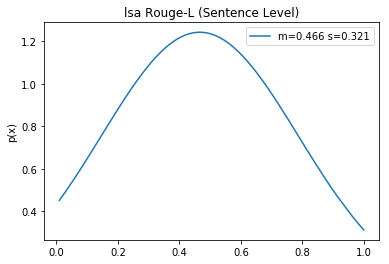

In [12]:
for col in static_lsa.columns:
    x = [i for i in static_lsa.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("lsa " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2ext_lsa_"+col+".png")

## text-rank 그래프

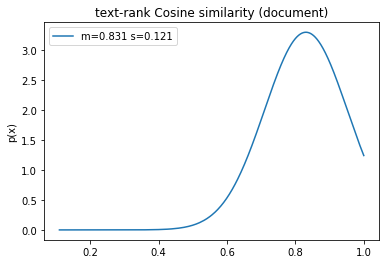

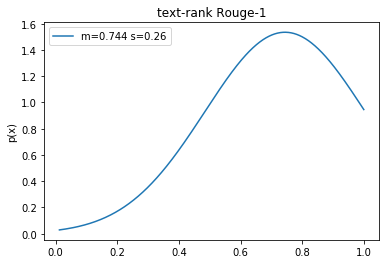

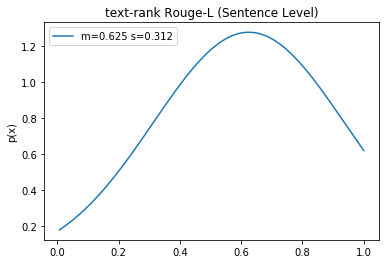

In [13]:
for col in static_text_rank.columns:
    x = [i for i in static_text_rank.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("text-rank " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2ext_text-rank_"+col+".png")

## lex-rank 그래프

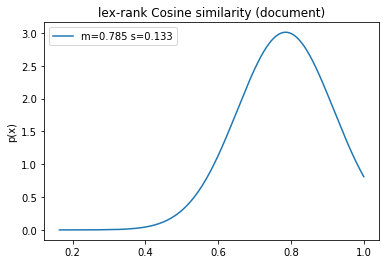

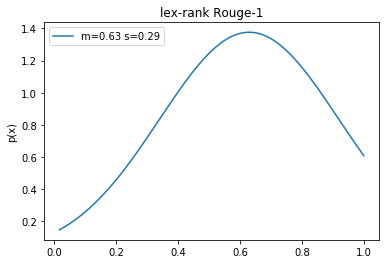

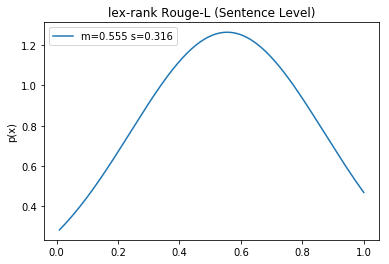

In [14]:
for col in static_lex_rank.columns:
    x = [i for i in static_lex_rank.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("lex-rank " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2ext_lex-rank_"+col+".png")

## sum-basic 그래프

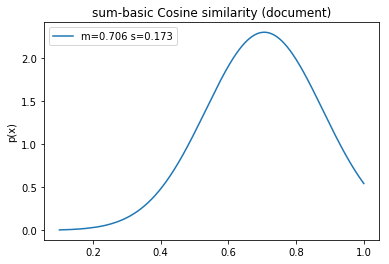

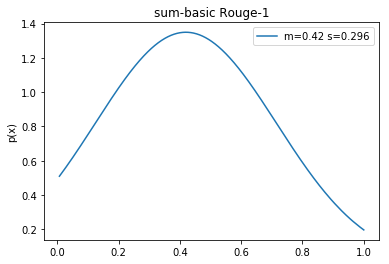

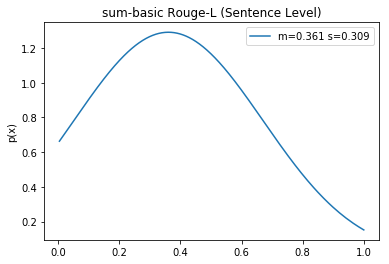

In [15]:
for col in static_sum_basic.columns:
    x = [i for i in static_sum_basic.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("sum-basic " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2ext_sum-basic_"+col+".png")

## kl 그래프

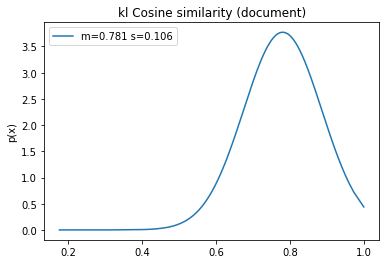

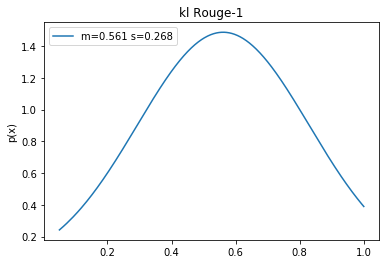

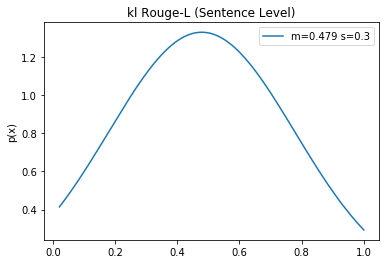

In [16]:
for col in static_kl.columns:
    x = [i for i in static_kl.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kl " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2ext_kl_"+col+".png")

# 한국어

In [9]:
kor_text = pd.read_csv("news_kor.csv",header=None, encoding='utf-8')
kor_text_all=kor_text[1].values[1:]

In [ ]:
#kor_reference_all = kor_text[0].values
kor_reference_all = pd.read_csv("kor_extract_luhn.csv", header=None, encoding = "utf-8").drop(0)
kor_reference_all = kor_reference_all[1].values

In [ ]:
for a, b in AVAILABLE_METHODS.items():
    names = "kor_txt2ext_result_"+a+".csv"
    raw_data = {'Precision':[], 'Recall':[], 'F-score':[], 'Cosine similarity':[], 'Cosine similarity (document)':[], 'Unit overlap':[], 'Unit overlap (document)':[], 'Rouge-1':[], 'Rouge-2':[], 'Rouge-L (Sentence Level)':[], 'Rouge-L (Summary Level)':[]}
    columns = [i[0] for i in AVAILABLE_EVALUATIONS]
    df = DataFrame(raw_data, columns = columns)
    #for i in range(1, len(kor_text_all)):
    for i in range(0, len(kor_reference_all)):
        summarizer_builder = b
        parser = PlaintextParser(kor_text_all[i], Tokenizer('korean'))

        summarizer = summarizer_builder(parser, 'korean')
        document = parser.document
        items_count = ItemsCount(2)
        reference_summary = kor_reference_all[i]
        try:
            evaluated_sentences = summarizer(document, items_count)
        except:
            continue
        reference_document = PlaintextParser.from_string(reference_summary,Tokenizer("korean"))
        reference_sentences = reference_document.document.sentences
        raw_data = {}
        for name, evaluate_document, evaluate in AVAILABLE_EVALUATIONS:
            if evaluate_document:
                result = evaluate(evaluated_sentences, document.sentences)
            else:
                try :
                    result = evaluate(evaluated_sentences, reference_sentences)
                except :
                    break
            raw_data[name]=float(result)
        if(len(raw_data) == 11):
            df.loc[len(df)] = raw_data
    print("================================ "+ a + " done! ==============================")
    df.to_csv(names)

## 한국어 알고리즘별 그래프

In [ ]:
col = [i[0] for i in AVAILABLE_EVALUATIONS]
# luhn
static_luhn = pd.read_csv("kor_txt2ext_result_luhn.csv", header=None, encoding = "ISO-8859-1")
static_luhn = static_luhn.drop(0,0)
static_luhn = static_luhn.drop(0,1)
static_luhn.columns=col
static_luhn[col] = static_luhn[col].astype(float)
static_luhn = static_luhn.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# edmundson
static_edmundson = pd.read_csv("kor_txt2ext_result_edmundson.csv", header=None, encoding = "ISO-8859-1")
static_edmundson = static_edmundson.drop(0,0)
static_edmundson = static_edmundson.drop(0,1)
static_edmundson.columns=col
static_edmundson[col] = static_edmundson[col].astype(float)
static_edmundson = static_edmundson.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# lsa
static_lsa = pd.read_csv("kor_txt2ext_result_lsa.csv", header=None, encoding = "ISO-8859-1")
static_lsa = static_lsa.drop(0,0)
static_lsa = static_lsa.drop(0,1)
static_lsa.columns=col
static_lsa[col] = static_lsa[col].astype(float)
static_lsa = static_lsa.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# text-rank
static_text_rank = pd.read_csv("kor_txt2ext_result_text-rank.csv", header=None, encoding = "ISO-8859-1")
static_text_rank = static_text_rank.drop(0,0)
static_text_rank = static_text_rank.drop(0,1)
static_text_rank.columns=col
static_text_rank[col] = static_text_rank[col].astype(float)
static_text_rank = static_text_rank.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# lex-rank
static_lex_rank = pd.read_csv("kor_txt2ext_result_lex-rank.csv", header=None, encoding = "ISO-8859-1")
static_lex_rank = static_lex_rank.drop(0,0)
static_lex_rank = static_lex_rank.drop(0,1)
static_lex_rank.columns=col
static_lex_rank[col] = static_lex_rank[col].astype(float)
static_lex_rank = static_lex_rank.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# sum-basic
static_sum_basic = pd.read_csv("kor_txt2ext_result_sum-basic.csv", header=None, encoding = "ISO-8859-1")
static_sum_basic = static_sum_basic.drop(0,0)
static_sum_basic = static_sum_basic.drop(0,1)
static_sum_basic.columns=col
static_sum_basic[col] = static_sum_basic[col].astype(float)
static_sum_basic = static_sum_basic.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

#kl
static_kl = pd.read_csv("kor_txt2ext_result_kl.csv", header=None, encoding = "ISO-8859-1")
static_kl = static_kl.drop(0,0)
static_kl = static_kl.drop(0,1)
static_kl.columns=col
static_kl[col] = static_kl[col].astype(float)
static_kl = static_kl.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

## luhn 그래프

In [ ]:
for col in static_luhn.columns:
    x = [i for i in static_luhn.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor luhn " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2ext_luhn_"+col+".png")

## edmundson 그래프

In [ ]:
for col in static_edmundson.columns:
    x = [i for i in static_edmundson.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor edmundson " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2ext_edmundson_"+col+".png")

## lsa 그래프

In [ ]:
for col in static_lsa.columns:
    x = [i for i in static_lsa.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor lsa " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2ext_lsa_"+col+".png")

## text-rank 그래프

In [ ]:
for col in static_text_rank.columns:
    x = [i for i in static_text_rank.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor text-rank " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2ext_text-rank_"+col+".png")

## lex-rank 그래프

In [ ]:
for col in static_lex_rank.columns:
    x = [i for i in static_lex_rank.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor lex-rank " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2ext_lex-rank_"+col+".png")

## sum-basic 그래프

In [ ]:
for col in static_sum_basic.columns:
    x = [i for i in static_sum_basic.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor sum-basic " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2ext_sum-basic_"+col+".png")

## kl 그래프

In [ ]:
for col in static_kl.columns:
    x = [i for i in static_kl.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor kl " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2ext_kl_"+col+".png")